In [26]:
%matplotlib inline

Importing used modules:

In [27]:
import numpy as np
import datetime
from flixOpt.flixStructure import *
from flixOpt.flixComps import *

# Creating Timeseries: ##

In [28]:
Q_th_Last = np.array([30., 0., 90., 110, 110, 20, 20, 20, 20])  # kW; thermal load profile in
p_el = 1 / 1000 * np.array([80., 80., 80., 80, 80, 80, 80, 80, 80])  # €/kWh; feed_in tariff;
aTimeSeries = datetime.datetime(2020, 1, 1) + np.arange(len(Q_th_Last)) * datetime.timedelta(
    hours=1)  # creating timeseries
aTimeSeries = aTimeSeries.astype('datetime64')  # needed format for timeseries in flixOpt
max_emissions_per_hour = 1000  # kg per timestep

## Bus-Definition: ##
define buses for the 3 used media:

In [29]:
Strom = cBus(media='el', label='Strom')  # balancing node/bus of electricity
Fernwaerme = cBus(media='heat', label='Fernwaerme')  # balancing node/bus of heat
Gas = cBus(media='fuel', label='Gas')  # balancing node/bus of gas

## Effect-Definition: ##

In [30]:
costs = cEffectType('costs', '€', 'Kosten',  # name, unit, description
                    isStandard=True,  # standard effect --> shorter input possible (without effect as a key)
                    isObjective=True)  # defining costs as objective of optimiziation

CO2 = cEffectType('CO2', 'kg', 'CO2_e-Emissionen',  # name, unit, description
                  specificShareToOtherEffects_operation={costs: 0.2},
                  max_per_hour_operation=max_emissions_per_hour)  # 0.2 €/kg; defining links between effects, here CO2-price

## Component-Definition: ##

In [31]:
# # 1. heat supply units: #

# 1.a) defining a boiler
aBoiler = cKessel('Boiler', eta=0.5,  # name, efficiency factor
                  # defining the output-flow = thermal -flow
                  Q_th=cFlow(label='Q_th',  # name of flow
                             bus=Fernwaerme,  # define, where flow is linked to (here: Fernwaerme-Bus)
                             nominal_val=50,  # kW; nominal_size of boiler
                             min_rel=5 / 50,  # 10 % minimum load, i.e. 5 kW
                             max_rel=1,  # 100 % maximum load, i.e. 50 kW
                             ),
                  # defining the input-flow = fuel-flow
                  Q_fu=cFlow(label='Q_fu',  # name of flow
                             bus=Gas)  # define, where flow is linked to (here: Gas-Bus)
                  )

# 2.b) defining a CHP unit:
aKWK = cKWK('CHP_unit', eta_th=0.5, eta_el=0.4,  # name, thermal efficiency, electric efficiency
            # defining flows:
            P_el=cFlow('P_el', bus=Strom,
                       nominal_val=60,  # 60 kW_el
                       min_rel=5 / 60, ),
            # 5 kW_el, min- and max-load (100%) are here defined through this electric flow
            Q_th=cFlow('Q_th', bus=Fernwaerme),
            Q_fu=cFlow('Q_fu', bus=Gas))

# # 2. storage #
aSpeicher = cStorage('Speicher',
                     inFlow=cFlow('Q_th_load', bus=Fernwaerme, nominal_val=1e4),
                     # load-flow, maximum load-power: 1e4 kW
                     outFlow=cFlow('Q_th_unload', bus=Fernwaerme, nominal_val=1e4),
                     # unload-flow, maximum load-power: 1e4 kW
                     capacity_inFlowHours=30,  # 30 kWh; storage capacity
                     chargeState0_inFlowHours=0,  # empty storage at first time step
                     max_rel_chargeState=1 / 100 * np.array([80., 70., 80., 80, 80, 80, 80, 80, 80, 80]),
                     eta_load=0.9, eta_unload=1,  # loading efficiency factor, unloading efficiency factor
                     fracLossPerHour=0.08,  # 8 %/h; 8 percent of storage loading level is lossed every hour
                     avoidInAndOutAtOnce=True,  # no parallel loading and unloading at one time
                     investArgs=cInvestArgs(fixCosts=20,
                                            investmentSize_is_fixed=True,
                                            investment_is_optional=False)
                     )

### Sinks and Sources

In [32]:
# sink of heat load:
aWaermeLast = cSink('Wärmelast',
                    # defining input-flow:
                    sink=cFlow('Q_th_Last',  # name
                               bus=Fernwaerme,  # linked to bus "Fernwaerme"
                               nominal_val=1,  # nominal_value
                               val_rel=Q_th_Last))  # fixed profile
# relative fixed values (timeseries) of the flow
# value = val_rel * nominal_val

# source of gas:
aGasTarif = cSource('Gastarif',
                    # defining output-flow:
                    source=cFlow('Q_Gas',  # name
                                 bus=Gas,  # linked to bus "Gas"
                                 nominal_val=1000,  # nominal size, i.e. 1000 kW maximum
                                 # defining effect-shares.
                                 #    Here not only "costs", but also CO2-emissions:
                                 costsPerFlowHour={costs: 0.04, CO2: 0.3}))  # 0.04 €/kWh, 0.3 kg_CO2/kWh

# sink of electricity feed-in:
aStromEinspeisung = cSink('Einspeisung',
                          # defining input-flow:
                          sink=cFlow('P_el',  # name
                                     bus=Strom,  # linked to bus "Strom"
                                     costsPerFlowHour=-1 * p_el))  # gains (negative costs) per kWh

Name 'Wärmelast' ist nicht Attributnamen-konform und wird zu 'Waermelast' geändert


## Build energysystem - Registering of all elements

In [33]:
es = cEnergySystem(aTimeSeries, dt_last=None)  # creating system, (duration of last timestep is like the one before)
es.addComponents(aSpeicher)  # adding components
es.addEffects(costs, CO2)  # adding defined effects
es.addComponents(aBoiler, aWaermeLast, aGasTarif)  # adding components
es.addComponents(aStromEinspeisung)  # adding components
es.addComponents(aKWK)  # adding components

# choose used timeindexe:
chosenEsTimeIndexe = None  # all timeindexe are used
# chosenEsTimeIndexe = [1,3,5] # only a subset shall be used

Register new Component Speicher
Register new effect costs
Register new effect CO2
Register new Component Boiler
Register new Component Waermelast
Register new Component Gastarif
Register new Component Einspeisung
Register new Component CHP_unit


## Modeling the System

In [34]:
# 1. create a Calculation
aCalc = cCalculation('Sim1',  # name of calculation
                     es,  # energysystem to calculate
                     'pyomo',  # optimization modeling language (only "pyomo" implemented, yet)
                     chosenEsTimeIndexe)  # used time steps

# 2. modeling:
aCalc.doModelingAsOneSegment()  # mathematic modeling of system, Modeling as one Segement

# 3. (optional) print Model-Characteristics:
es.printModel()  # string-output:network structure of model
es.printVariables()  # string output: variables of model
es.printEquations()  # string-output: equations of model

### some Solver-Inputs: ###
solverProps = {'gapFrac': 0.0001,  # solver-gap
               'timelimit': 3600,  # seconds until solver abort
               'solver': 'highs',  # Other possible solver (need to install): glpk, gurobi, cbc
               'displaySolverOutput': True, # ausführlicher Solver-Output.
               }
aCalc.solve(solverProps)  # nameSuffix for the results
# .. results are saved under /results/
# these files are written:
# -> json-file with model- and solve-Informations!
# -> log-file
# -> data-file

!!! ACHTUNG in Speicher__Q_th_load : Binärdefinition mit großem Max-Wert (10000). Ggf. falsche Ergebnisse !!!
!!! ACHTUNG in Speicher__Q_th_unload : Binärdefinition mit großem Max-Wert (10000). Ggf. falsche Ergebnisse !!!


finalize all MEs...
Speicher
Boiler
Waermelast
Gastarif
Einspeisung
CHP_unit
Fernwaerme
Gas
Strom
globalComp
costs
CO2
Q_fu
P_el
Q_th
Q_th_unload
P_el
Q_th_load
Q_th
Q_th_Last
Q_Gas
Q_fu
modeling costs
modeling CO2
declareVarsAndEqs Q_th_load
declareVarsAndEqs Q_th_unload
declareVarsAndEqs Q_fu
declareVarsAndEqs Q_th
declareVarsAndEqs Q_th_Last
declareVarsAndEqs Q_Gas
declareVarsAndEqs P_el
declareVarsAndEqs Q_fu
declareVarsAndEqs P_el
declareVarsAndEqs Q_th

##############################################################
########## Short String Description of Energysystem ##########

buses:
  Fernwaerme:
    In-Flows:
    - Q_th_unload:
        comp: Speicher
    - Q_th:
        comp: Boiler
    - Q_th:
        comp: CHP_unit
    Out-Flows:
    - Q_th_load:
        comp: Speicher
    - Q_th_Last:
        comp: Waermelast
    class: cBus
  Gas:
    In-Flows:
    - Q_Gas:
        comp: Gastarif
    Out-Flows:
    - Q_fu:
        comp: Boiler
    - Q_fu:
        comp: CHP_unit
    class: 

# PostProcessing: #

In [35]:
# ##### loading results from output-files ######
import flixOpt.flixPostprocessing as flixPost
nameOfCalc = aCalc.nameOfCalc
# loading results, creating postprocessing Object:
aCalc_post = flixPost.flix_results(nameOfCalc)

# Plotting
#### Plotting all in- and out-flows of bus "Fernwaerme":

#### Plotting all in- and out-flows of bus "Fernwaerme":

/var/folders/1z/xs11s8cd563_dhtnmk53bxpr0000gn/T/ipykernel_48559/2785207247.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



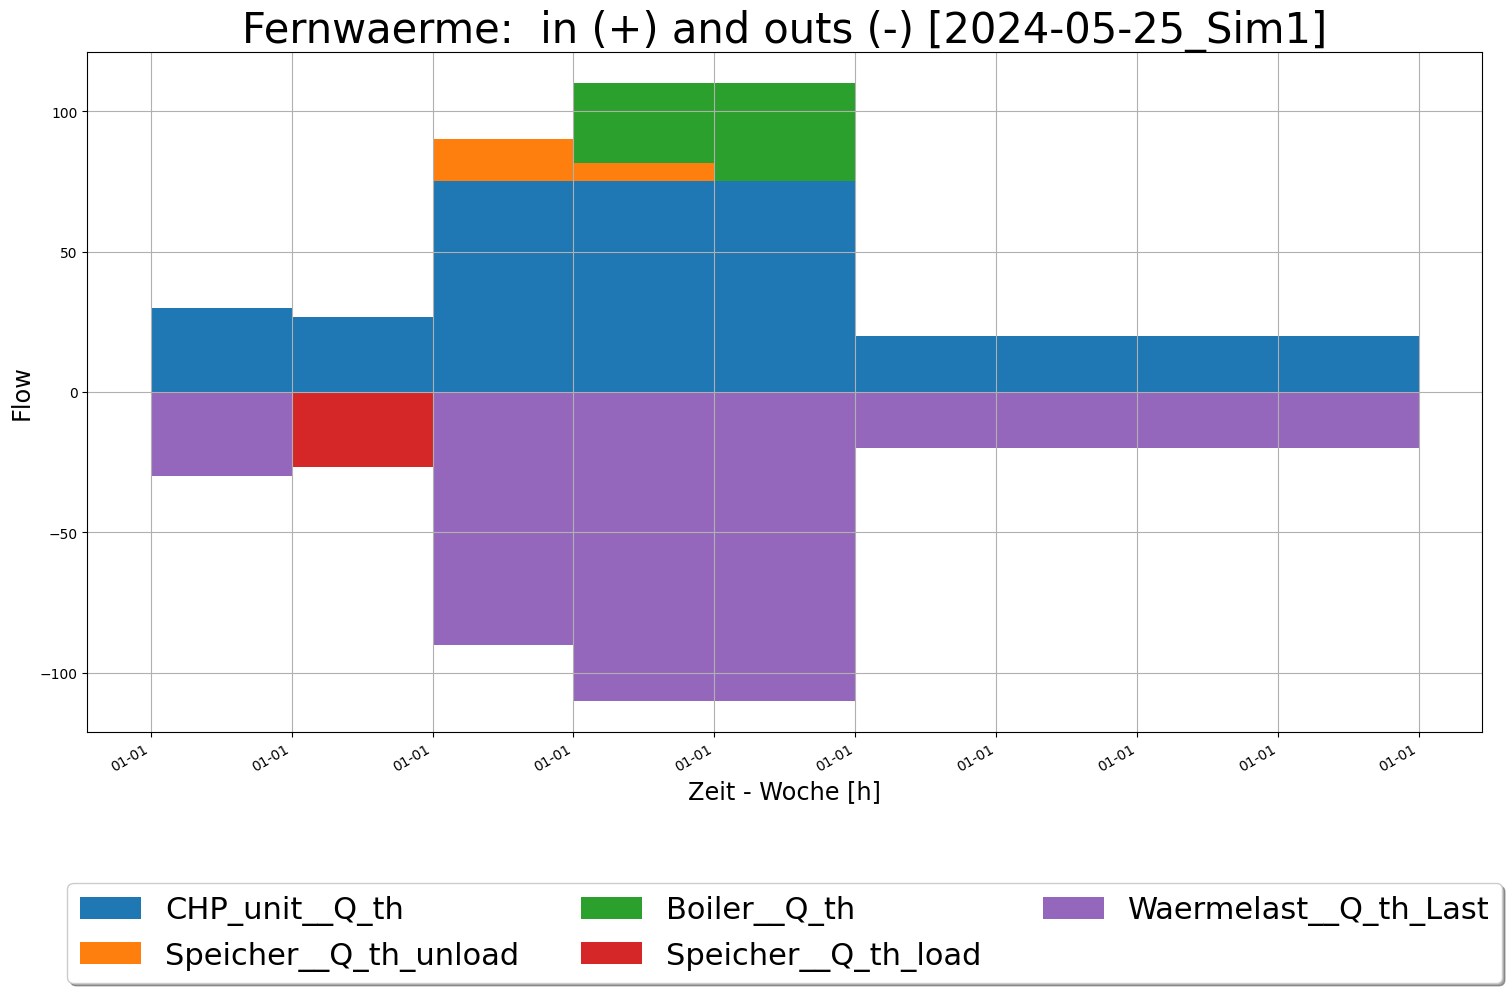

In [36]:
fig2 = aCalc_post.plotInAndOuts('Fernwaerme', stacked=True)
fig2.show()

In [37]:
fig3 = aCalc_post.plotInAndOuts('Strom', stacked=True, plotAsPlotly=True)
fig3.show()

## access to timeseries: ##

In [38]:
# 1. direct access:
# (not recommended, better use postProcessing instead, see next)
print('# direct access:')
print('way 1:')
print(aCalc.results['Boiler']['Q_th']['val'])  # access through dict
print('way 2:')
print(aCalc.results_struct.Boiler.Q_th.val)  # access matlab-struct like
print('way 3:')
print(aBoiler.Q_th.mod.var_val.getResult())  # access directly through component/flow-variables
#    (warning: there are only temporarily the results of the last executed solve-command of the energy-system)

# 2. post-processing access:
print('# access to timeseries:#')
print('way 1:')
print(aCalc_post.results['Boiler']['Q_th']['val'])  # access through dict
print('way 2:')
print(aCalc_post.results_struct.Boiler.Q_th.val)  # access matlab-struct like
print('way 3:')
# find flow:
aFlow_post = aCalc_post.getFlowsOf('Fernwaerme', 'Boiler')[0][0]  # getting flow
print(aFlow_post.results['val'])  # access through cFlow_post object

# direct access:
way 1:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]
way 2:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]
way 3:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]
# access to timeseries:#
way 1:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]
way 2:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]
way 3:
[ 0.      0.      0.     28.4864 35.      0.      0.      0.      0.    ]


## saving csv of special flows of bus "Fernwaerme" ##

In [39]:
aCalc_post.to_csv('Fernwaerme', 'results/FW.csv')